In [1]:
import numpy as np
import numba
import time
import concurrent.futures
from numpy.random import Generator, PCG64DXSM, SeedSequence
from math import floor
from sys import float_info
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import ipynbname

from FNs_genBachStravinsky_v0055k_assort_FLIP7_rep_execNULLsig_SMARTmutation import genBSreplicatorexec_full_play_typed, population_array, mutual_info, average_mutual_info, getalphasignaling

np.set_printoptions(suppress=True)
np.set_printoptions(threshold=np.inf)


In [2]:
runpass = ipynbname.name()
thrds = 8

runs = 1000
runlength = 4*10**4
record_interval = runlength
signal_snapshots = 1 # need this to be 1 for correct sweep measures of the presence of the desired topology

population_size = 1*10**3
numtypes = 4
mutation_rate = np.array([0.01, 0.1])
# percent_agents_per_type = [.5, .5]
sigdimensions = 2
numsignals_perdim = np.array([2, 2])
numsignals = np.prod(numsignals_perdim)
# print(numsignals)
sigmultipliers = np.cumprod(numsignals_perdim)
sigmultipliers = np.roll(sigmultipliers, 1)
sigmultipliers[0] = 1
# print(sigmultipliers)



base_connection_weights = np.array([1, 2, 4, 8, 16, 32]) #this should be at least one longer than the number of sig dimensions
# reinforcement = 10
# punishment = -2
numactions = 4
# coordination_preferences = np.array([[1, 1], [1, 1]])
genBSpunish = np.ones((2))*0
signal_cost = -0.0002 # this should be a negative value if not 0
inertia = 1
homophily_factor = 0
epsilon = float_info.epsilon #add this value to random uniform distribution to get (0, 1] instead of [0, 1)

# repmultipliers is like sigmultipliers, but maps entire strategy profile for both senders and receivers to a unique value
# modifying this to add in executives after receivers
dimactions= list(numsignals_perdim)
for dadex in range(0, numsignals):
    dimactions.append(numactions)
# for dadex2 in range(0, sigdimensions): # this is added in for executives # ***** removed for 54b
#     dimactions.append(2) # appending 2 because executive is always 0 for ignore dimension or 1 for attend dimension
dimactions = np.array(dimactions)
numprofiles = np.prod(dimactions)
print(numprofiles)
repmultipliers = np.cumprod(dimactions)
repmultipliers = np.roll(repmultipliers, 1)
repmultipliers[0] = 1
print(repmultipliers)



1024
[  1   2   4  16  64 256]


In [3]:
# # ________________________________________________________________________________________________
# t0sigs = [[0, 1], [1, 0]]
# t1sigs = [1, 1]
# print(t0sigs)
# print(t1sigs)
# print(' ')
# t0sigs_index = []
# t1sigs_index = []
# for intdex3 in range(0, len(t0sigs)):
#     t0s = 0
#     t1s = 0
#     for intdex4 in range(0, sigdimensions):
#         t0s += t0sigs[intdex3][intdex4]*sigmultipliers[intdex4]
#         t1s += t1sigs[intdex4]*sigmultipliers[intdex4]
#     t0sigs_index.append(t0s)
#     t1sigs_index.append(t1s)
# print(t0sigs_index)
# print(t1sigs_index)

In [4]:

payoff_alphas = [0, 1, 2]
cents_offset = [-0.1, 0, 0.1]

concise0_topINT = np.zeros((3, 3))
concise1_topINT = np.zeros((3, 3))
concise2_topINT = np.zeros((3, 3))
concise3_topINT = np.zeros((3, 3))
concise4_topINT = np.zeros((3, 3))

for dex0 in range(0, 3):
    for dex1 in range(0, 3):
        start = time.perf_counter() # starting a timer to see how long it takes simulation to run

        pa = payoff_alphas[dex0]
        co = cents_offset[dex1]

        percent_agents_per_type = [0.2-0.5*co, .2+co, .2-0.5*co, 0.4]

        coordination_preferences = np.array([[1, 0, 0, 0.5], [1, pa, 1, .5], [0, 0, 1, .5], [0, 0, 0, 1]])


        sq1 = SeedSequence()
        randomentropy = sq1.entropy
        # randomentropy = 198033477696915839319494177136675262199
        print(randomentropy)
        sg = SeedSequence(randomentropy)
        rgs = numba.typed.List([Generator(PCG64DXSM(s)) for s in sg.spawn(runs)])


        sigurns = []
        for idx0000 in range(0, sigdimensions):
            sigurns.append(np.ones([population_size, numsignals_perdim[idx0000]])*inertia)

        recurns = np.ones([population_size, numsignals, numactions])*inertia
        popt = population_array(population_size, percent_agents_per_type)

        uniquepopt, countspopt = np.unique(popt, return_counts=True)
        print(np.asarray((uniquepopt, countspopt)).T)


        # initiallizing some arrays to store results in
        final_simple_stat_001 = np.zeros((runs, numtypes, numtypes, numactions), dtype=np.int64)
        final_simple_stat_002 = np.zeros((runs, numtypes, numtypes, numactions), dtype=np.int64)
        final_socialsig_aggregate = np.zeros((runs, signal_snapshots, numtypes, numsignals), dtype=np.int64)
        final_action_aggregate = np.zeros((runs, numtypes, numsignals, numactions), dtype=np.int64)
        final_sigurns = []
        final_recurns = []
        final_execurns = np.zeros((runs, population_size, sigdimensions), dtype=np.int64)
        final_typed_time = np.zeros((runs, numtypes, numsignals, numactions, runlength//record_interval), dtype=np.float64)
        final_signal_time = np.zeros((runs, numsignals, numsignals, numactions, runlength//record_interval), dtype=np.float64)
        final_typed_time_norm = np.zeros((runs, numtypes, numsignals, numactions, runlength//record_interval), dtype=np.float64)
        final_signal_time_norm = np.zeros((runs, numsignals, numsignals, numactions, runlength//record_interval), dtype=np.float64)
        for final_idx in range(0, runs):
            final_sigurns.append(sigurns)
            final_recurns.append(recurns)

        inputs = []

        with concurrent.futures.ProcessPoolExecutor(max_workers=thrds) as executor:
            future_to_genBS = {executor.submit(genBSreplicatorexec_full_play_typed, mutation_rate, signal_cost, repmultipliers, numprofiles, signal_snapshots, record_interval, genBSpunish, numtypes, numsignals, runlength, numactions, coordination_preferences, popt, sigurns, recurns, population_size, sigdimensions, base_connection_weights, sigmultipliers, homophily_factor, rgs[r], epsilon, r): inputs for r in range(runs)}
            for future in concurrent.futures.as_completed(future_to_genBS):
                inputs = future_to_genBS[future]
                try:
                    data_simple_stat_002, data_simple_stat_001, data_socialsig_aggregate, data_action_aggregate, data_sigurns, data_recurns, data_execurns, data_typed_time, data_signal_time, data_typed_time_norm, data_signal_time_norm, data_runid = future.result()
                except Exception as exc:
                    print(f'generated an exception: y? and {exc}')
                else:
                    final_simple_stat_001[data_runid] = data_simple_stat_001
                    final_simple_stat_002[data_runid] = data_simple_stat_002
                    final_socialsig_aggregate[data_runid] = data_socialsig_aggregate
                    final_action_aggregate[data_runid] = data_action_aggregate
                    final_sigurns[data_runid] = data_sigurns
                    final_recurns[data_runid] = data_recurns
                    final_execurns[data_runid] = data_execurns
                    final_typed_time[data_runid] = data_typed_time
                    final_signal_time[data_runid] = data_signal_time
                    final_typed_time_norm[data_runid] = data_typed_time_norm
                    final_signal_time_norm[data_runid] = data_signal_time_norm
                    if data_runid%100 == 0:
                        print(f'finished run #{data_runid}')

        # for testruns in range(0, runs):
        #     data_simple_stat_002, data_simple_stat_001, data_socialsig_aggregate, data_action_aggregate, data_sigurns, data_recurns, data_typed_time, data_signal_time, data_typed_time_norm, data_signal_time_norm, data_runid = genBSreplicator_full_play_typed(mutation_rate, signal_cost, repmultipliers, numprofiles, signal_snapshots, record_interval, genBSpunish, numtypes, numsignals, runlength, numactions, coordination_preferences, popt, sigurns, recurns, population_size, sigdimensions, base_connection_weights, sigmultipliers, homophily_factor, rgs[testruns], epsilon, testruns)
        #     final_simple_stat_002[testruns] = data_simple_stat_002
        #     final_simple_stat_001[testruns] = data_simple_stat_001
        #     final_socialsig_aggregate[testruns] = data_socialsig_aggregate
        #     final_action_aggregate[testruns] = data_action_aggregate
        #     final_sigurns[testruns] = data_sigurns
        #     final_recurns[testruns] = data_recurns
        # #                     final_execurns[testruns] = data_execurns
        #     final_typed_time[testruns] = data_typed_time
        #     final_signal_time[testruns] = data_signal_time
        #     final_typed_time_norm[testruns] = data_typed_time_norm
        #     final_signal_time_norm[testruns] = data_signal_time_norm
        #     print(f'finished run #{testruns}')


        print('_____________________________________________________________________________')
        print(f'{runpass}_{dex0}_{dex1}') 
        print('payoffs =')
        print(coordination_preferences)
        print(f'punish = {genBSpunish}')
        print(f'signal cost = {signal_cost}')
        print(f'percent of agent types = {percent_agents_per_type}')
        print(f'homophily = {homophily_factor}')
        final_simple_stat_001array = np.array(final_simple_stat_001)
        final_simple_stat_001mean = np.mean(final_simple_stat_001array, axis = 0)
        print(final_simple_stat_001mean)
        final_simple_stat_002array = np.array(final_simple_stat_002)
        final_simple_stat_002mean = np.mean(final_simple_stat_002array, axis = 0)
        print('final simple stat 2:')
        print(final_simple_stat_002mean)

        average_mutuinfo = average_mutual_info(numsignals, sigdimensions, sigmultipliers, numactions, final_sigurns, final_recurns, population_size, runs)
        print(f'average mutual information = {average_mutuinfo}')

#         np.savez(f'{runpass}_{dex0}_{dex1}_.npz', final_mean=final_simple_stat_001mean, final_array2=final_simple_stat_002array, final_array=final_simple_stat_001array, final_socialsig=final_socialsig_aggregate, final_action=final_action_aggregate, final_sig=final_sigurns, final_rec=final_recurns, final_exec=final_execurns, final_typetime=final_typed_time, final_sigtime=final_signal_time, final_typetime_norm=final_typed_time_norm, final_sigtime_norm=final_signal_time_norm)

        type0 = 0
        type0opposition = np.array([1])
        type0agree = np.array([1])
        multidimsignalscount0, runsmultidimsignalscount0, oppositiondisruns0, agreeruns0, execsruns0, meanexecsruns0 = getalphasignaling(popt, final_execurns, type0, type0opposition, type0agree, sigmultipliers, population_size, final_sigurns, numsignals_perdim, sigdimensions, runs, numtypes, numsignals)


        print(' ')
        print('type 0 alphas:')
        print(multidimsignalscount0)

        print('execs attenton 0 alphas:')
        print(meanexecsruns0)
        print(' ')

        concisecount0 = 0
        concisecount1 = 0
        concisecount2 = 0
        concisecount3 = 0
        concisecount4 = 0
        for concisedex in range(0, runs):
            cstat = final_simple_stat_001[concisedex]
            cstat2 = final_simple_stat_002[concisedex]
            estat = execsruns0[concisedex]
            if np.sum(estat[0])==1:
                if np.sum(estat[1])==2:
                    if np.sum(estat[2])==1:
                        if np.sum(estat[3])==0:
                            if np.argmax(final_socialsig_aggregate[concisedex][0][0]) != np.argmax(final_socialsig_aggregate[concisedex][0][2]):
                                concisecount0 += 1
                                if cstat2[0][3][3] == 1 and (cstat2[1][3][3] == 1 and (cstat2[2][3][3] == 1 and cstat2[3][3][3] == 1)):
                                    if cstat2[0][0][0] == 1 and cstat2[2][2][2] ==1:
                                        if cstat2[1][0][0] ==1 and cstat2[1][2][2] ==1:
                                            if cstat2[1][1][0] == 1:
                                                concisecount1 += 1
                                                concisecount3 += 1
                                            elif cstat2[1][1][2] == 1:
                                                concisecount2 += 1
                                                concisecount3 += 1
                                            elif cstat2[1][1][1] == 1:
                                                concisecount4 += 1


        concise0_topINT[dex0][dex1] = concisecount0
        concise1_topINT[dex0][dex1] = concisecount1
        concise2_topINT[dex0][dex1] = concisecount2
        concise3_topINT[dex0][dex1] = concisecount3
        concise4_topINT[dex0][dex1] = concisecount4
        print(f'Signaling is correct: concise0 count = {concisecount0}')
        print(f'type 1s do 0s preferred action with eachother: concise1 count = {concisecount1}')
        print(f'type 1s do 2s preferred action with eachother: concise2 count = {concisecount2}')
        print(f'concise3 is just consise1 + consise2 count = {concisecount3}')
        print(f'type 1s do 1s preferred action with eachother: concise4 count = {concisecount4}')
        finish = time.perf_counter()
        print(f'Finished in {round(finish-start,0)/60} minutes')
        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        print(' ')
        print(' ')
                

# np.save(f'{runpass}_{dex0}_{dex1}_concise1_topC.npy', concise1_topC)
# np.save(f'{runpass}_{dex0}_{dex1}_concise2_topC.npy', concise2_topC)
# np.save(f'{runpass}_{dex0}_{dex1}_concise3_topC.npy', concise3_topC)


194207437240965870059739130823504548371
[[  0 250]
 [  1 100]
 [  2 250]
 [  3 400]]
finished run #0
finished run #100
finished run #200
finished run #300
finished run #400
finished run #500
finished run #600
finished run #700
finished run #800
finished run #900
_____________________________________________________________________________
genBS_v0055k_assort_FLIP7_repEXEC_sm_sweep_Merced_top_intersec_0_0
payoffs =
[[1.  0.  0.  0.5]
 [1.  0.  1.  0.5]
 [0.  0.  1.  0.5]
 [0.  0.  0.  1. ]]
punish = [0. 0.]
signal cost = -0.0002
percent of agent types = [0.25, 0.1, 0.25, 0.4]
homophily = 0
[[[0.953 0.    0.    0.047]
  [1.    0.    0.    0.   ]
  [0.    0.    0.    1.   ]
  [0.    0.    0.    1.   ]]

 [[1.    0.    0.    0.   ]
  [0.386 0.    0.333 0.281]
  [0.    0.    0.998 0.002]
  [0.024 0.    0.023 0.953]]

 [[0.    0.    0.    1.   ]
  [0.    0.    0.998 0.002]
  [0.    0.    0.951 0.049]
  [0.    0.    0.    1.   ]]

 [[0.    0.    0.    1.   ]
  [0.    0.    0.    1.   ]
  [0. 

In [5]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

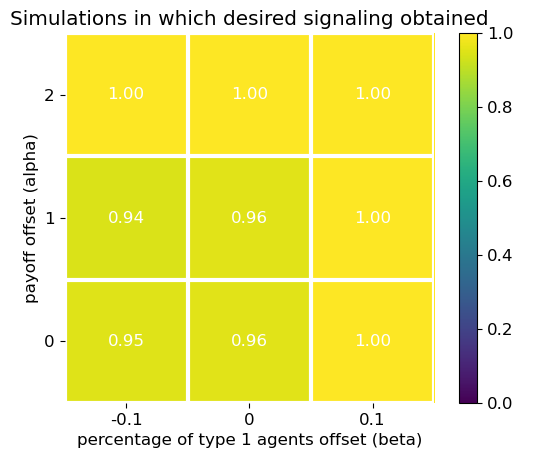

In [9]:
plt.rcParams.update({'font.size': 12})

xval = cents_offset
yval = np.flip(payoff_alphas)

heatmap_array = np.flip(concise0_topINT, axis=0)/runs

fig, ax = plt.subplots()

# im, cbar = heatmap(heatmap_array, yval, xval, ax=ax,
#                    cmap="viridis", norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
#                                               vmin=0, vmax=1.0, base=10), cbarlabel="no coordination percent")

im, cbar = heatmap(heatmap_array, yval, xval, ax=ax,
                   cmap="viridis", vmin=0, vmax=1, cbarlabel=" ")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.title('Simulations in which desired signaling obtained')
plt.xlabel('percentage of type 1 agents offset (beta)')
plt.ylabel('payoff offset (alpha)')
fig = plt.gcf()
plt.show()
fig.savefig(f'heatmap_concise0_topINT_{runpass}.png')


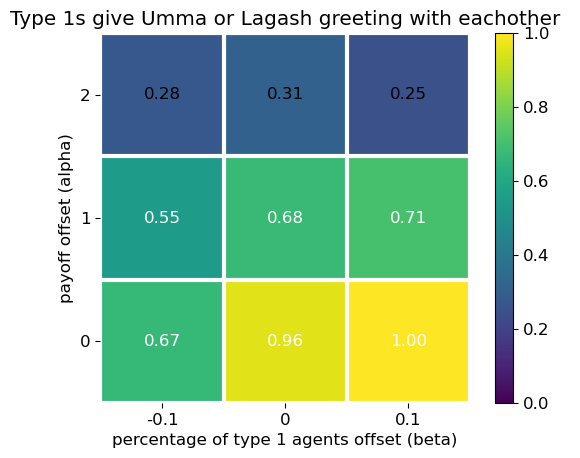

In [10]:


xval = cents_offset
yval = np.flip(payoff_alphas)

heatmap_array = np.flip(concise3_topINT, axis=0)/runs

fig, ax = plt.subplots()

# im, cbar = heatmap(heatmap_array, yval, xval, ax=ax,
#                    cmap="viridis", norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
#                                               vmin=0, vmax=1.0, base=10), cbarlabel="no coordination percent")

im, cbar = heatmap(heatmap_array, yval, xval, ax=ax,
                   cmap="viridis", vmin=0, vmax=1, cbarlabel=" ")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.title('Type 1s give Umma or Lagash greeting with eachother')
plt.xlabel('percentage of type 1 agents offset (beta)')
plt.ylabel('payoff offset (alpha)')
fig = plt.gcf()
plt.show()
fig.savefig(f'heatmap_concise3_topINT_{runpass}.png')


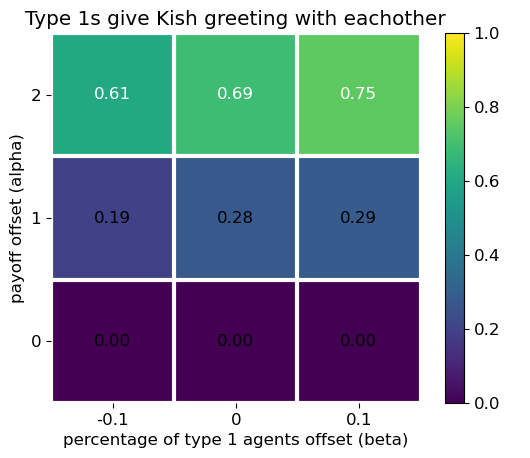

In [11]:


xval = cents_offset
yval = np.flip(payoff_alphas)

heatmap_array = np.flip(concise4_topINT, axis=0)/runs

fig, ax = plt.subplots()

# im, cbar = heatmap(heatmap_array, yval, xval, ax=ax,
#                    cmap="viridis", norm=matplotlib.colors.SymLogNorm(linthresh=0.03, linscale=0.03,
#                                               vmin=0, vmax=1.0, base=10), cbarlabel="no coordination percent")

im, cbar = heatmap(heatmap_array, yval, xval, ax=ax,
                   cmap="viridis", vmin=0, vmax=1, cbarlabel=" ")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

plt.title('Type 1s give Kish greeting with eachother')
plt.xlabel('percentage of type 1 agents offset (beta)')
plt.ylabel('payoff offset (alpha)')
fig = plt.gcf()
plt.show()
fig.savefig(f'heatmap_concise4_topINT_{runpass}.png')


In [4]:
a = np.array([[[1, 0], [1, 0]], [[1, 0], [1, 0]]])
b = np.array([[[0, 1], [0, 1]], [[0, 1], [0, 1]]])
c = np.array([[[1, 0], [1, 0]], [[1, 0], [0, 1]]])
d = np.array([[[1, 0], [0, 1]], [[0, 1], [0, 1]]])
e = np.array([[[1, 0], [1, 0]], [[0, 1], [0, 1]]])
acount = 0
bcount = 0
ccount = 0
dcount = 0
ecount = 0
elist = []

for printdex in range(0, runs):
    print(final_simple_stat_001array[printdex], printdex)
    print(' ')
    if np.array_equal(final_simple_stat_001array[printdex], a):
        acount+=1
    elif np.array_equal(final_simple_stat_001array[printdex], b):
        bcount+=1
    elif np.array_equal(final_simple_stat_001array[printdex], c):
        ccount+=1
    elif np.array_equal(final_simple_stat_001array[printdex], d):
        dcount+=1
    elif np.array_equal(final_simple_stat_001array[printdex], e):
        ecount+=1
        elist.append(printdex)
print(f'{a} outcomes')
print(f'there are {acount}')
print(' ')
print(f'{b} outcomes')
print(f'there are {bcount}')
print(' ')
print(f'{c} outcomes')
print(f'there are {ccount}')
print(' ')
print(f'{d} outcomes')
print(f'there are {dcount}')
print(' ')
print(f'{e} outcomes')
print(f'there are {ecount}')
print(elist)
print(' ')
print(acount+bcount+ccount+dcount+ecount)

[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 0
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 1
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 2
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 1 0]]] 3
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 4
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 5
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 1]]] 6
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 1]]] 7
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 8
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 9
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 10
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 11
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 12
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 1]]] 13
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 1]]] 14
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 1]]] 15
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 16
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 17
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0]
  [0 0 1]]] 18
 
[[[1 0 0]
  [0 0 1]]

 [[0 0 1]
  [0 0 1]]] 19
 
[[[1 0 0]
  [1 0 0]]

 [[1 0 0

In [29]:
# final_recurns[0]

[[246 254]
 [249 251]]


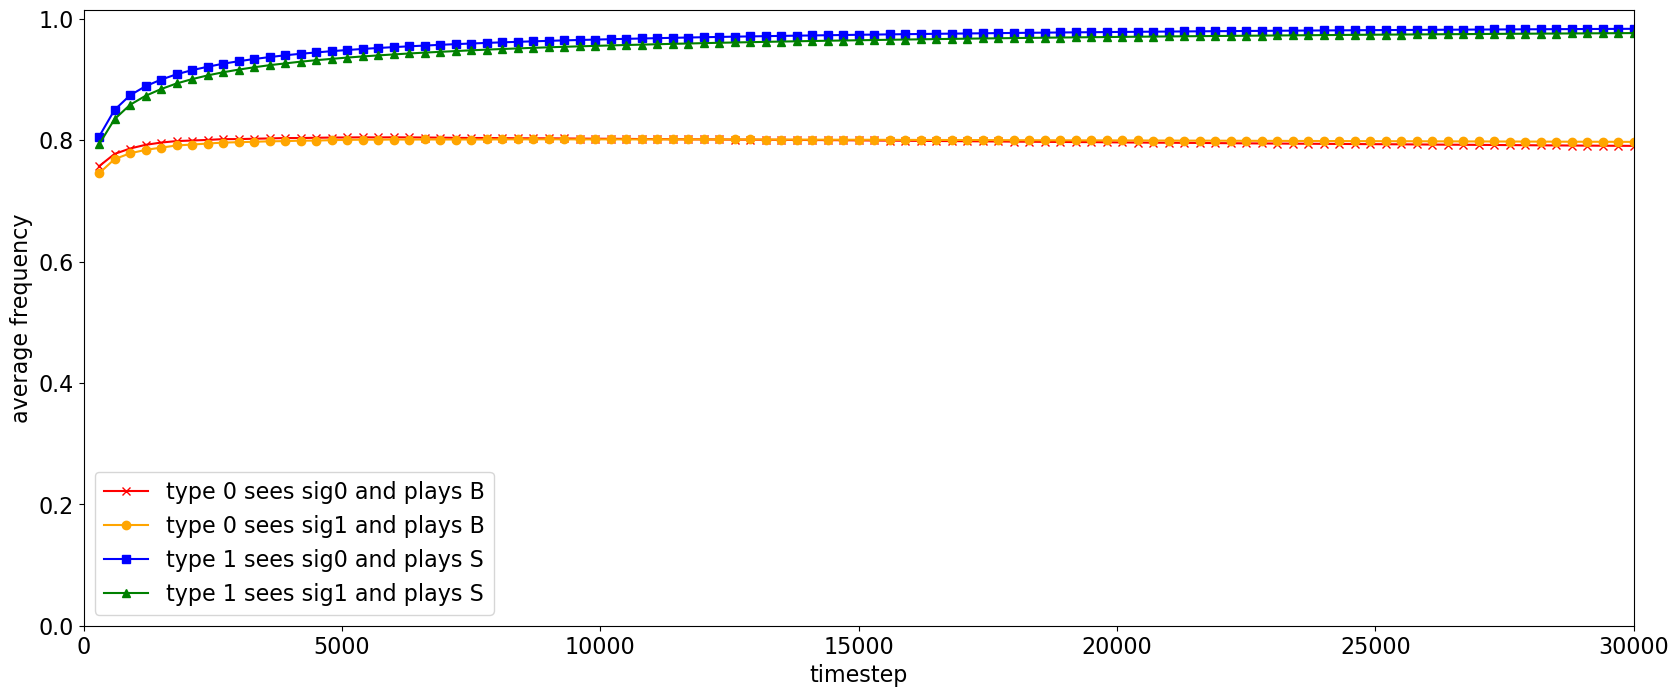

In [32]:
run_number = 0 # interesting runs: 0*, 2
print(final_socialsig_aggregate[run_number])

xaxis = np.arange(record_interval, runlength+record_interval, record_interval)

figure(num=None, figsize=(20, 8), dpi=100, facecolor='w', edgecolor='k')


plt.rcParams.update({'font.size': 16})

plt.plot(xaxis, final_typed_time[run_number][0][0][0], label=f"type 0 sees sig0 and plays B", marker='x', color='red')
plt.plot(xaxis, final_typed_time[run_number][0][1][0], label=f"type 0 sees sig1 and plays B", marker='o', color='orange')
plt.plot(xaxis, final_typed_time[run_number][1][0][1], label=f"type 1 sees sig0 and plays S", marker='s', color='blue')
plt.plot(xaxis, final_typed_time[run_number][1][1][1], label=f"type 1 sees sig1 and plays S", marker='^', color='green')

plt.axis([0, runlength, 0.0, 1.015])
# plt.title('Betabinomial PMF')
plt.xlabel('timestep')
plt.ylabel('average frequency')
plt.legend()
# plt.savefig(f'IMAGE_typedtime_{runpass}_negative_rein_percent0_{percent_agents_per_type[0]}_punish{genBSpunish}_apay{coordination_preferences[0][0]}runlength{runlength}.png')
plt.show()


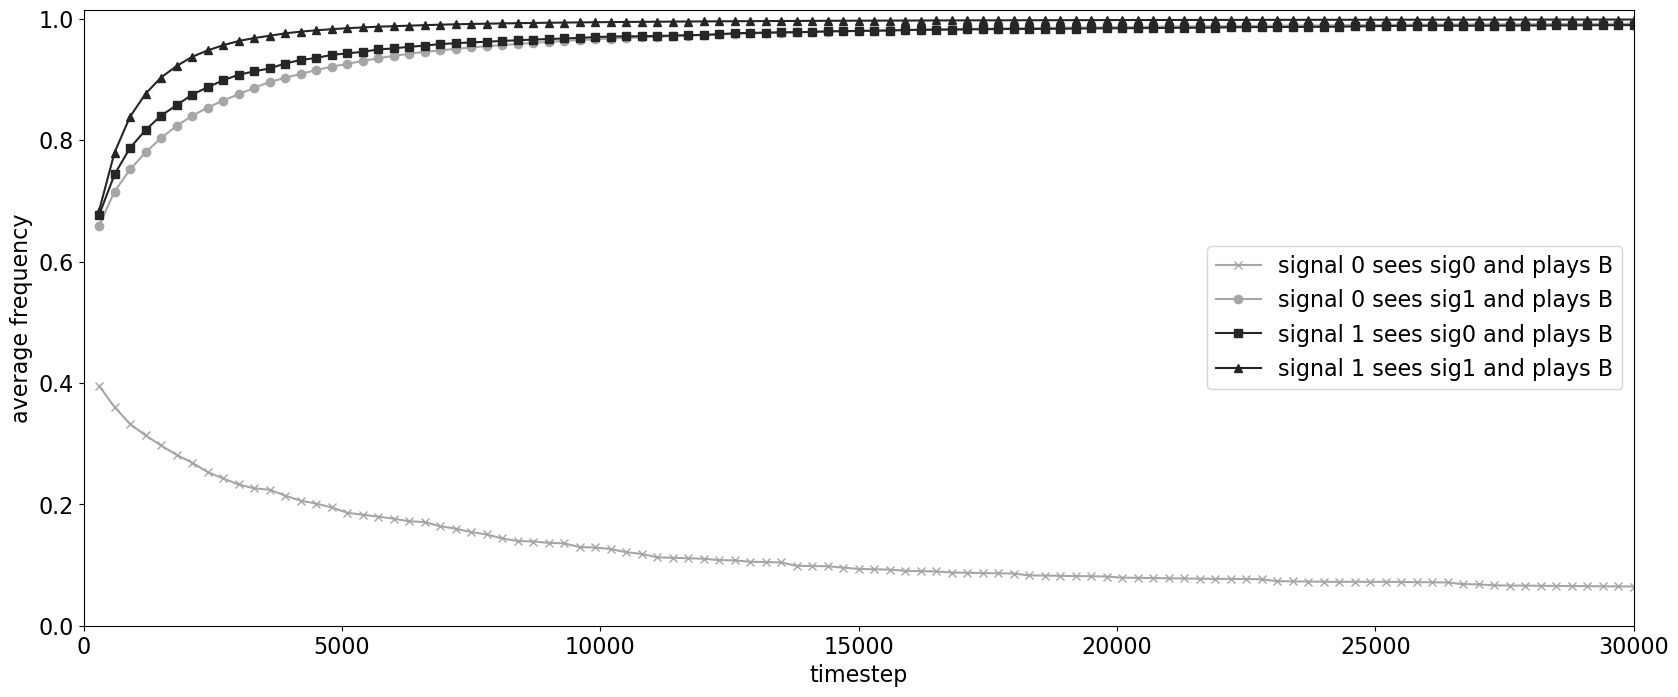

In [22]:

xaxis = np.arange(record_interval, runlength+record_interval, record_interval)

figure(num=None, figsize=(20, 8), dpi=100, facecolor='w', edgecolor='k')


plt.rcParams.update({'font.size': 16})

plt.plot(xaxis, final_signal_time[run_number][0][0][0], label=f"signal 0 sees sig0 and plays B", marker='x', c='0.65')
plt.plot(xaxis, final_signal_time[run_number][0][1][0], label=f"signal 0 sees sig1 and plays B", marker='o', c='0.65')
plt.plot(xaxis, final_signal_time[run_number][1][0][0], label=f"signal 1 sees sig0 and plays B", marker='s', c='0.15')
plt.plot(xaxis, final_signal_time[run_number][1][1][0], label=f"signal 1 sees sig1 and plays B", marker='^', c='0.15')

plt.axis([0, runlength, 0.0, 1.015])
# plt.title('Betabinomial PMF')
plt.xlabel('timestep')
plt.ylabel('average frequency')
plt.legend()
# plt.savefig(f'IMAGE_signaltime_{runpass}_negative_rein_percent0_{percent_agents_per_type[0]}_punish{genBSpunish}_apay{coordination_preferences[0][0]}runlength{runlength}.png')
plt.show()


In [7]:
print(final_socialsig_aggregate[2])
# print(np.argmax(final_socialsig_aggregate[2][0]))
print(final_action_aggregate[2])
# print(np.argmax(final_action_aggregate[2][0][1]))

[[229 271]
 [258 242]]
[[[500   0]
  [500   0]]

 [[500   0]
  [500   0]]]
